# Deep Learning in Medicine

## BMSC-GA 4493, BMIN-GA 3007

## Lab 7: Autoencoders
credits: Juiting Hsu

## Goal:
    1. Understand the architecture of autoendcoders
    2. Denoise auto-encoder

## Why Autoencoder:
    - Denoise data: reduce data dimensions and learning to ignore the noise in the data.
## Architecture:    
    1. Encoder stage: map an input to a hidden state through an affine transformation $h= f(W_{h}x + b)$, where f is an element-wise activation function. Represent input in an encoded representation.
    2. Decoder stage: $\hat{x} = g(W_{x}h + b)$. Reconstruct the input as close as the original input.


## Code

In [21]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import time
import copy

torch.manual_seed(1111);

In [24]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [25]:
device

device(type='cpu')

## Data

In [6]:
batch_size = 64
# Data Loader
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize(torch.tensor([0.5]),torch.tensor([0.5]))
                   ])),
    batch_size=batch_size, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize(torch.tensor([0.5]),torch.tensor([0.5]))
                   ])),
    batch_size=batch_size, shuffle=True)

0it [00:00, ?it/s]

9920512it [00:00, 10575653.21it/s]                            


Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw


32768it [00:00, 541458.50it/s]
  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw


1654784it [00:00, 6651512.59it/s]                              
8192it [00:00, 160621.82it/s]


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw
Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw
Processing...
Done!


In [7]:
def plot_digits(digits):
    grids = make_grid(digits, nrow=8)
    plt.figure(figsize=(12, 9))
    plt.imshow(grids.numpy()[0], cmap='gray')

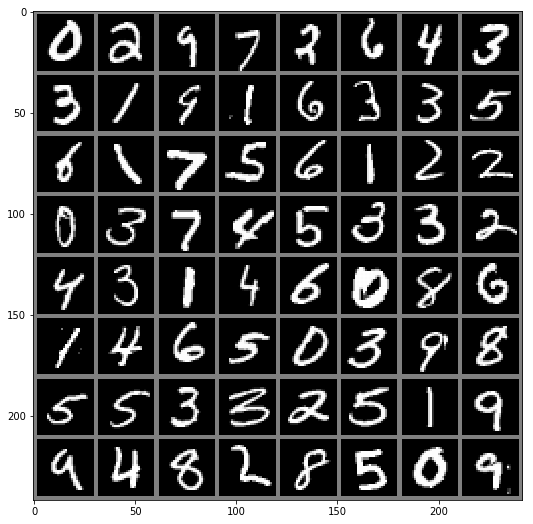

In [8]:
data, label = next(iter(train_loader))
plot_digits(data)

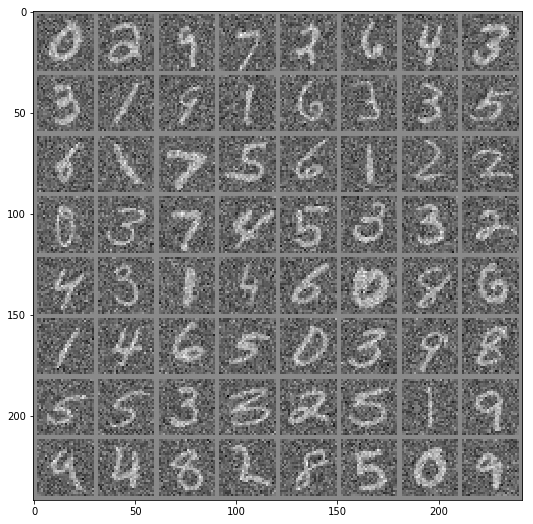

In [9]:
plot_digits(data + torch.FloatTensor(data.size()).normal_(mean=0, std=0.6))

## Model: Denoising Auto-encoder

As covered in class, there are mainly two components to an autoencoder: an encoder and a decoder. For this tutorial, we will be using a very simple model with just one hidden layer (not including the output layer), as shown by the image below. The decoder will just be the mirror of the encoder. Rather than learning an undercomplete representation, we will attempt to learn an overcomplete representation by training a [**sparse autoencoder**](https://web.stanford.edu/class/cs294a/sparseAutoencoder_2011new.pdf). In other words, the "code" that our autoencoder learn will be of the same dimension as the input data (28 * 28 = 784). We will, however, add a dropout layer to enforce the sparsity.

Another thing to note is that rather than treating out input as 2-dimensional (28 x 28), we will transform our input to 1-dimensional vectors (784) for simplicity.

<img src="https://cdn-images-1.medium.com/max/1600/1*ZEvDcg1LP7xvrTSHt0B5-Q@2x.png" alt="alt text" width="300" height="120">

A simple version of autoencoder. If you're looking for a more complex architecture, it would probably be better to write separate classes of Encoder and Decoder, then include them both in the model. However, since we're using pretty straightforward MLPs, we can do that in a single class by utilizing the ```nn.Sequential``` module.

In [10]:
class AutoEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, code_dim, dropout_rate=0.15):
        """
        :param input_dim: dimension of input to autoencoder
        :param hidden_dim: dimension of hidden layer in encoder and decoder
        :param code_dim: dimension of code in autoencoder
        """
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
                                     nn.Linear(input_dim, hidden_dim),
                                     nn.ReLU(),
                                     nn.Linear(hidden_dim, code_dim),
                                     nn.ReLU()
                                    )
        self.decoder = nn.Sequential(
                                     nn.Linear(code_dim, hidden_dim),
                                     nn.ReLU(),
                                     nn.Linear(hidden_dim, input_dim),
                                     nn.Tanh())
        self.dropout = nn.Dropout(p=dropout_rate)
        
    def forward(self, x):
        """
        Forward function for the autoencoder. Remember to add dropout to enforce sparsity!
        Return both the output from the decoder and the code from the encoder
        :return output, code
        """
        code = self.encoder(x)
        out = self.decoder(self.dropout(code))
        return out, code

## Training

Next, we will train our autoencoder to denoise handwritten digit image data. Use the functions below and complete the code where necessary. Think about what kind of loss to use as the reconstruction loss for this task.

In [11]:
def test_model(loader, model, limit=None):
    """
    Help function that tests the models's performance on a dataset
    :param: loader: data loader for the dataset to test against
    """
    loss = 0
    num_samples = 0
    
    model.eval()
    
    predictions = []
    truths = []
    
    for i, (data, labels) in enumerate(loader):
        if i and i==limit:
            break
        data_noise = data + torch.FloatTensor(data.size()).normal_(std=NOISE_STD)
        outputs, _ = model(data_noise.squeeze().view(-1, 28 * 28).to(device))
        # compute loss
        loss += loss_function(outputs, data.view(-1,28*28).to(device)).item() * data.size()[0]
        num_samples += data.size()[0]

    return loss/num_samples

In [12]:
def train(num_epoch, model):
    for epoch in range(num_epoch):
        for i, (data, labels) in enumerate(train_loader):
            model.train()
            # add gaussian noise to data
            data_noise = data + torch.FloatTensor(data.size()).normal_(std=NOISE_STD)
            
            outputs, _ = model(data_noise.squeeze().view(-1, 28 * 28).to(device))
            model.zero_grad()
            loss = loss_function(outputs, data.view(-1,28*28).to(device))
            loss.backward()
            optimizer.step()

             # report performance
            if (i + 1) % LOG_INTERVAL == 0:
                test_loss = test_model(test_loader, model)
                print('Epoch: [{0}/{1}], Step: [{2}/{3}], Train Loss: {4}, Validation Loss:{5}'.format(
                    epoch + 1, EPOCHS, i + 1, len(train_loader), loss.item(), test_loss))

In [26]:
EPOCHS = 6
LOG_INTERVAL = 300

LR = 0.002
NOISE_STD = 0.6

model = AutoEncoder(28 * 28, 200, 784).to(device)

# TODO: loss function for reconstruction loss
loss_function = nn.MSELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=LR)

train(EPOCHS, model)

Epoch: [1/6], Step: [300/938], Train Loss: 0.09133728593587875, Validation Loss:0.08516071749925613
Epoch: [1/6], Step: [600/938], Train Loss: 0.08210673183202744, Validation Loss:0.06814771144986152
Epoch: [1/6], Step: [900/938], Train Loss: 0.06882941722869873, Validation Loss:0.06050221937298775
Epoch: [2/6], Step: [300/938], Train Loss: 0.0587921068072319, Validation Loss:0.05792598750591278
Epoch: [2/6], Step: [600/938], Train Loss: 0.06194716691970825, Validation Loss:0.053725232148170474
Epoch: [2/6], Step: [900/938], Train Loss: 0.06693962216377258, Validation Loss:0.05296536950469017
Epoch: [3/6], Step: [300/938], Train Loss: 0.05524883046746254, Validation Loss:0.05173771685361862
Epoch: [3/6], Step: [600/938], Train Loss: 0.054026756435632706, Validation Loss:0.050060295099020005
Epoch: [3/6], Step: [900/938], Train Loss: 0.06072651594877243, Validation Loss:0.04904704386591911
Epoch: [4/6], Step: [300/938], Train Loss: 0.059569668024778366, Validation Loss:0.048547312414646

## Visualize Results

Let's take a look at how we can use our trained model:

Text(0.5, 1.0, 'Sampled original data')

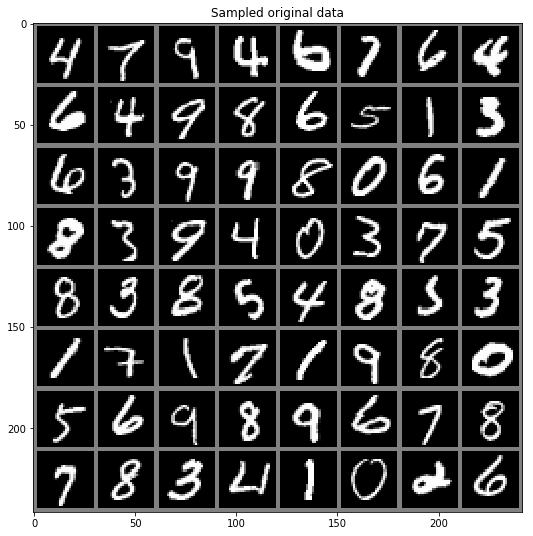

In [27]:
data, label = next(iter(test_loader))
plot_digits(data)
plt.title("Sampled original data")

Text(0.5, 1.0, 'Data with Gaussian noise')

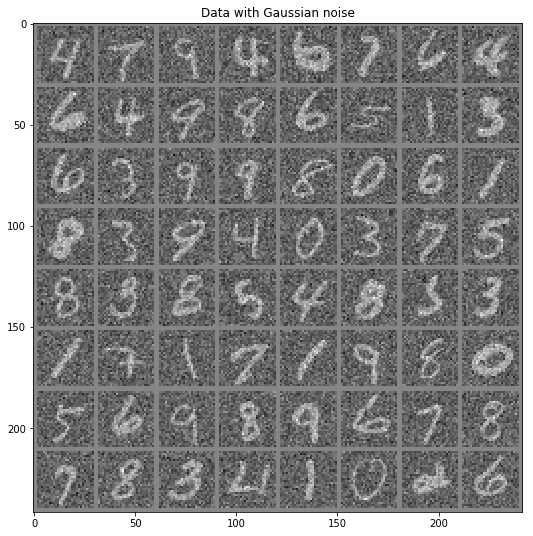

In [29]:
data_noise = data + torch.FloatTensor(data.size()).normal_(mean=0, std=NOISE_STD)
plot_digits(data_noise)
plt.title("Data with Gaussian noise")

In [34]:
data_noise.view(-1, 28 * 28).shape

torch.Size([64, 784])

Text(0.5, 1.0, 'Reconstructed (denoised) images')

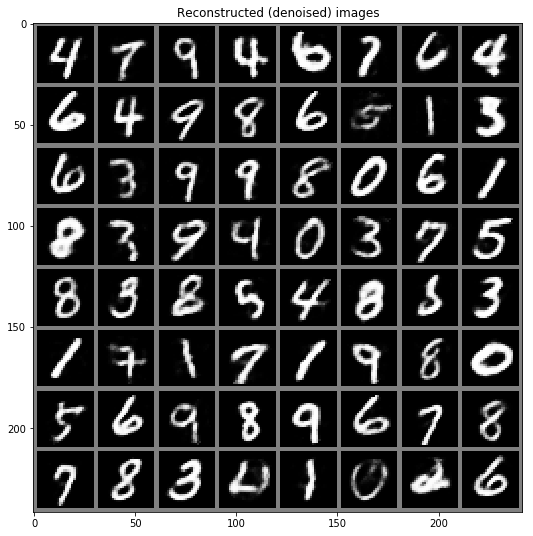

In [30]:
# denoise the data
model.eval()
reconstruction, _ = model(data_noise.view(-1, 28 * 28).to(device))

reconstruction = reconstruction.view(-1, 1, 28, 28).data.cpu()
plot_digits(reconstruction)
plt.title("Reconstructed (denoised) images")

## An application of autoencoders
Stacked What Where Autoencoders -  https://arxiv.org/pdf/1506.02351.pdf

# Visualization of High dimensional vectors using t-SNE

Useful Link to understand t-SNE and how to interpret the visualization: https://distill.pub/2016/misread-tsne/

In [35]:
from sklearn.manifold import TSNE

In [36]:
tsne = TSNE(perplexity=50)

In [37]:
data_np = []
y_np = []
encoded_data_np = []
for data in train_loader:
    encoded_data = model.encoder(data[0].view(-1,28*28).to(device)).cpu().detach().numpy()
    encoded_data_np.append(encoded_data)
    data_np.append(data[0].view(-1,28*28).numpy())
    y_np.append(data[1].numpy())
data_np = np.concatenate(data_np, axis = 0)[:2500,:]
y_np = np.concatenate(y_np)[:2500]
encoded_data_np = np.concatenate(encoded_data_np,axis = 0)[:2500,:]

In [38]:
red_data = tsne.fit_transform(data_np)

In [39]:
red_encoded = tsne.fit_transform(encoded_data_np)

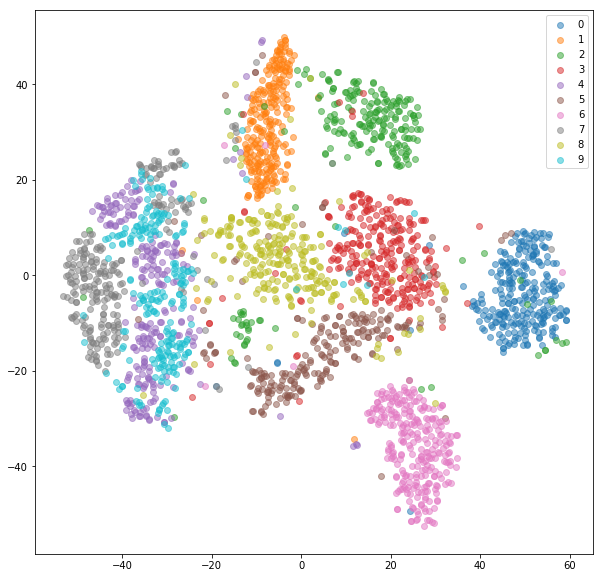

In [40]:
plt.figure(figsize = (10,10))
for i in range(10):
    plt.scatter(red_data[:,0][y_np == i],red_data[:,1][y_np == i], label = str(i), alpha = 0.5)
plt.legend()

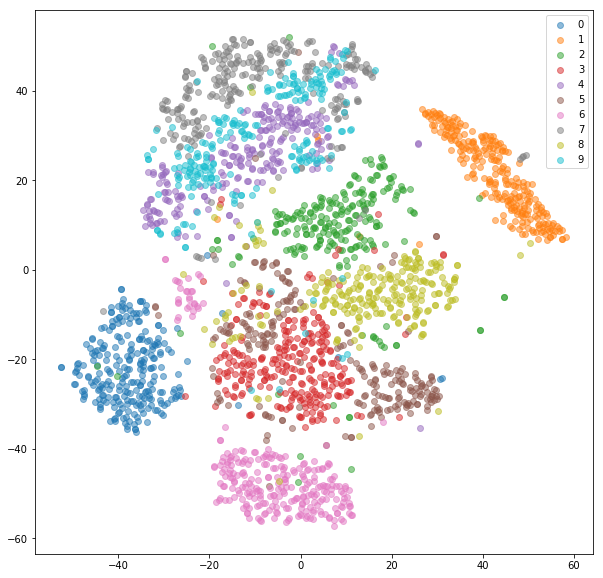

In [41]:
plt.figure(figsize = (10,10))
for i in range(10):
    plt.scatter(red_encoded[:,0][y_np == i],red_encoded[:,1][y_np == i], label = str(i), alpha = 0.5)
plt.legend()